In [ ]:
import pandas as pd

train = pd.read_csv('/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv')
test = pd.read_csv('/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv')


In [ ]:
# Import XGBoost and other necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import numpy as np

In [ ]:
# Check data shape and target distribution
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"\nTarget distribution in training set:\n{train['label'].value_counts()}")

In [ ]:
# Prepare features and target
X_train = train.drop('label', axis=1)
y_train = train['label']

X_test = test.drop('label', axis=1)
y_test = test['label']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

In [ ]:
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Training completed!")

In [ ]:
# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Investigation: Is the dataset just too easy or is there still leakage?
from sklearn.metrics import confusion_matrix

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# Check if the dataset might just be linearly separable
print("\n=== Checking a simple baseline ===")
# Try a simple rule: predict based on just one feature
simple_pred = (X_test['IsHTTPS'] == 1).astype(int)
simple_accuracy = accuracy_score(y_test, simple_pred)
print(f"Accuracy using just 'IsHTTPS': {simple_accuracy:.4f}")

# Check feature importance to see what the model is relying on
print("\n=== Top 10 Feature Importances ===")
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_imp.head(10))

In [ ]:
# Simple XGBoost with Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Load data
train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv")
test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

# Separate features and target
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Categorical column names: {categorical_cols}")

# Build preprocessing pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Create full pipeline with XGBoost
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

# Cross-validation on training data
print("\n=== Cross-Validation ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"CV AUC Scores: {auc_scores}")
print(f"Mean CV AUC: {auc_scores.mean():.4f} (+/- {auc_scores.std():.4f})")

# Train on full training set
print("\n=== Training on Full Training Set ===")
pipeline.fit(X_train, y_train)
print("Training completed!")

# Evaluate on training set
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Evaluate on test set
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n=== Test Set Performance ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred))

In [1]:
# 11_xgboost.py - Fixed version with NO DATA LEAKAGE
# 
# KEY FIX: Feature engineering (especially location binning) is now done INSIDE
# the pipeline using FeatureEngineerTransformer. This ensures that loc_groups
# are computed separately for each CV fold, preventing target leakage.
#
# Previous issue in 10_xgboost_onehot.py:
# - apply_feature_engineering(train) was called BEFORE cross_val_score
# - map_loc_bin computed location->target mappings using the FULL training set
# - These mappings leaked into CV, making CV scores optimistically biased
#
# Solution:
# - FeatureEngineerTransformer.fit(X, y) computes loc_groups from training fold only
# - FeatureEngineerTransformer.transform(X) applies the learned mappings
# - Pipeline includes feature engineering as first step
# - CV properly fits feature engineering on train folds, transforms on validation folds

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = []
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = []
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['label'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop label if it exists (from fit phase)
        if 'label' in X_fe.columns:
            X_fe = X_fe.drop(columns=['label'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if label exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['label'] if 'label' in sample.columns else None
    if 'label' in sample.columns:
        sample = sample.drop(columns=['label'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # can do for textual variables
    # # TF-IDF + SVD for description
    # if 'description' in X_temp.columns:
    #     transformers.append((
    #         "desc_text",
    #         Pipeline([
    #             ("fill", FunctionTransformer(_fill_text_series, validate=False)),
    #             ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
    #             ("svd", TruncatedSVD(n_components=40, random_state=42))
    #         ]),
    #         'description'
    #     ))

    # # TF-IDF + SVD for screen_name
    # if 'screen_name' in X_temp.columns:
    #     transformers.append((
    #         "sn_text",
    #         Pipeline([
    #             ("fill", FunctionTransformer(_fill_text_series, validate=False)),
    #             ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
    #             ("svd", TruncatedSVD(n_components=8, random_state=42))
    #         ]),
    #         'screen_name'
    #     ))

    preprocessor = ColumnTransformer(transformers)

    # Optuna-tuned parameters
    model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.01818965322291987,
        max_depth=12,
        subsample=0.9089044013517584,
        colsample_bytree=0.5968303772495912,
        reg_alpha=0.34341485605720035,
        reg_lambda=1.7747160863049662,
        min_child_weight=4,
        gamma=0.5508393571724655,
        random_state=42,
        eval_metric="logloss"
    )

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),  # ✅ FIX: Inside pipeline!
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["label"])
    y = train["label"]

    # Build pipeline (pass raw X for schema discovery)
    print("🔨 Building pipeline...")
    pipeline = build_pipeline(X)

    # Cross-validation (pipeline handles feature engineering internally)
    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # Train full model
    print("\n🎯 Training final model on full training set...")
    pipeline.fit(X, y)
    
    # Save model
    # model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    # joblib.dump(pipeline, model_path)
    # print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "label": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    


🔨 Building pipeline...

🔄 Running 5-fold stratified cross-validation...
   (Feature engineering computed separately for each fold)

📊 CV Results:
   Mean AUC: 1.000000
   Std AUC:  0.000000
   Individual folds: ['1.000000', '1.000000', '1.000000', '1.000000', '1.000000']

🎯 Training final model on full training set...

🔮 Generating test predictions...
✅ Submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission.csv


## Random Forest

In [ ]:
# === Data Info ===
# Submission shape: (70739, 2)
# Test shape: (70739, 56)

# Submission columns: ['index', 'label']
# Submission head:
#    index     label
# 0      0  0.000011
# 1      1  0.002539
# 2      2  0.999884
# 3      3  1.000000
# 4      4  1.000000

# ==================================================
# === SUBMISSION PERFORMANCE ON TEST SET ===
# ==================================================
# Accuracy: 0.9999717270529693
# ROC-AUC:  1.0

# === Confusion Matrix ===
# [[40455     0]
#  [    2 30282]]

# True Negatives:  40,455
# False Positives: 0
# False Negatives: 2
# True Positives:  30,282

# === Classification Report ===
#               precision    recall  f1-score   support

#   Legitimate       1.00      1.00      1.00     40455
#     Phishing       1.00      1.00      1.00     30284

#     accuracy                           1.00     70739
#    macro avg       1.00      1.00      1.00     70739
# weighted avg       1.00      1.00      1.00     70739


# === Prediction Distribution ===
# Predicted Legitimate (0): 40,457 (57.19%)
# Predicted Phishing (1):   30,282 (42.81%)

# Actual Legitimate (0):    40,455 (57.19%)
# Actual Phishing (1):      30,284 (42.81%)

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import joblib
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier


def _fill_text_series(X):
    """Convert input array-like to a 1D numpy array of strings with NaNs filled."""
    s = pd.Series(np.asarray(X).ravel()).fillna('').astype(str).values
    return s


# ========= Feature Engineering Functions ========= #

def apply_feature_engineering(X, loc_groups=None, reference_date=None):
    return X, loc_groups


def map_loc_bin(df, loc_groups=None, min_samples=30, bins=None):
    return df, loc_groups


def cap_and_log(X):
    X = X.copy()
    log_cols = []
    for col in log_cols:
        if col in X.columns:
            X[col] = np.where(X[col] > 0, np.log1p(X[col]), 0)
    return X


def drop_columns(X):
    X = X.copy()
    drop_cols = []
    return X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")


# ========= Custom Transformer to Avoid Data Leakage ========= #

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Sklearn-compatible transformer that applies feature engineering.
    
    KEY: On fit(X, y) it computes location groups using the training fold's target.
    This prevents data leakage because each CV fold will compute its own loc_groups
    from its training split only.
    
    On transform(X) it applies feature engineering using the stored loc_groups.
    """
    def __init__(self, reference_date=None, min_samples=30):
        self.reference_date = reference_date
        self.min_samples = min_samples
        self.loc_groups_ = None

    def fit(self, X, y=None):
        """
        Fit on training data. Computes loc_groups from X and y.
        """
        if y is None:
            # No target provided, create empty loc_groups (will map all to 'other')
            # This happens during pipeline building when we discover schema
            self.loc_groups_ = {
                'mapping': {},
                'low_freq': [],
                'groups': {},
                'min_samples': self.min_samples,
                'bins': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
            }
            return self
        
        # Attach target temporarily to compute location mappings
        df = X.copy()
        df['label'] = np.asarray(y).ravel()
        
        # Compute loc_groups from this training fold only
        _, loc_groups = apply_feature_engineering(df, loc_groups=None, reference_date=self.reference_date)
        self.loc_groups_ = loc_groups
        return self

    def transform(self, X):
        """
        Transform data using the learned loc_groups (from fit).
        """
        X_fe, _ = apply_feature_engineering(X.copy(), loc_groups=self.loc_groups_, 
                                           reference_date=self.reference_date)
        # Drop label if it exists (from fit phase)
        if 'label' in X_fe.columns:
            X_fe = X_fe.drop(columns=['label'])
        return X_fe


# ========= Build Pipeline ========= #

def build_pipeline(X_sample):
    """
    Builds full preprocessing + model pipeline.
    
    Args:
        X_sample: A small sample of raw data (before feature engineering) to
                 determine column types after feature engineering
    """
    # Create feature engineering transformer
    feat_eng = FeatureEngineerTransformer()
    
    # Apply to sample to discover column schema (use dummy y if label exists in sample)
    sample = X_sample.head(100).copy()
    y_dummy = sample['label'] if 'label' in sample.columns else None
    if 'label' in sample.columns:
        sample = sample.drop(columns=['label'])
    X_sample_fe = feat_eng.fit_transform(sample, y_dummy)
    X_temp = drop_columns(cap_and_log(X_sample_fe))
    
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
    ])
    
    transformers = [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]

    # can do for textual variables
    # # TF-IDF + SVD for description
    # if 'description' in X_temp.columns:
    #     transformers.append((
    #         "desc_text",
    #         Pipeline([
    #             ("fill", FunctionTransformer(_fill_text_series, validate=False)),
    #             ("tfidf", TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')),
    #             ("svd", TruncatedSVD(n_components=40, random_state=42))
    #         ]),
    #         'description'
    #     ))

    # # TF-IDF + SVD for screen_name
    # if 'screen_name' in X_temp.columns:
    #     transformers.append((
    #         "sn_text",
    #         Pipeline([
    #             ("fill", FunctionTransformer(_fill_text_series, validate=False)),
    #             ("tfidf", TfidfVectorizer(max_features=500, ngram_range=(1,2))),
    #             ("svd", TruncatedSVD(n_components=8, random_state=42))
    #         ]),
    #         'screen_name'
    #     ))

    preprocessor = ColumnTransformer(transformers)

    # Optuna-tuned parameters
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    # Complete pipeline with feature engineering INSIDE
    pipeline = Pipeline([
        ("feature_engineering", FeatureEngineerTransformer()),  # ✅ FIX: Inside pipeline!
        ("cap_log", FunctionTransformer(cap_and_log, validate=False)),
        ("drop", FunctionTransformer(drop_columns, validate=False)),
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    return pipeline


# ========= Main ========= #

if __name__ == "__main__":

    # Load data
    train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv")
    test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

    # Prepare training data (NO feature engineering here!)
    X = train.drop(columns=["label"])
    y = train["label"]

    # Build pipeline (pass raw X for schema discovery)
    print("🔨 Building pipeline...")
    pipeline = build_pipeline(X)

    # Cross-validation (pipeline handles feature engineering internally)
    print("\n🔄 Running 5-fold stratified cross-validation...")
    print("   (Feature engineering computed separately for each fold)")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc", error_score='raise')
    
    print(f"\n📊 CV Results:")
    print(f"   Mean AUC: {auc_scores.mean():.6f}")
    print(f"   Std AUC:  {auc_scores.std():.6f}")
    print(f"   Individual folds: {[f'{s:.6f}' for s in auc_scores]}")

    # Train full model
    print("\n🎯 Training final model on full training set...")
    pipeline.fit(X, y)
    
    # Save model
    # model_path = "/Users/maximus/Downloads/SCHOOL/bt4012/bt-4012-in-class-kaggle-competiton-1-2025/models/xgboost_pipeline_fixed.pkl"
    # joblib.dump(pipeline, model_path)
    # print(f"✅ Model saved to: {model_path}")

    # Predict on test (pipeline handles feature engineering)
    print("\n🔮 Generating test predictions...")
    test_probs = pipeline.predict_proba(test)[:, 1]

    submission = pd.DataFrame({
        "index": test.index,
        "label": test_probs
    })

    submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission.csv"
    submission.to_csv(submission_path, index=False)
    print(f"✅ Submission saved to: {submission_path}")
    


## LightGBM

In [6]:
# LightGBM Implementation
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data
train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv")
test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

# Separate features and target
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("=== Data Overview ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Categorical column names: {categorical_cols}")

# Build preprocessing pipelines
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(max_categories=40, handle_unknown='infrequent_if_exist'))
])

# Combine transformers
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Create full pipeline with LightGBM
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ))
])

# Cross-validation on training data
print("\n=== Cross-Validation ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(lgbm_pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"CV AUC Scores: {auc_scores}")
print(f"Mean CV AUC: {auc_scores.mean():.4f} (+/- {auc_scores.std():.4f})")

# Train on full training set
print("\n=== Training LightGBM on Full Training Set ===")
lgbm_pipeline.fit(X_train, y_train)
print("Training completed!")

# Evaluate on training set
y_train_pred = lgbm_pipeline.predict(X_train)
y_train_proba = lgbm_pipeline.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Evaluate on test set
y_test_pred = lgbm_pipeline.predict(X_test)
y_test_proba = lgbm_pipeline.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n=== Test Set Performance ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

print("\n=== Confusion Matrix (Test Set) ===")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing']))

# Feature importance (from the trained LightGBM)
print("\n=== Top 20 Feature Importances ===")
# Get feature names after preprocessing
feature_names = (numeric_cols + 
                 list(lgbm_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['encoder']
                      .get_feature_names_out(categorical_cols)))

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lgbm_pipeline.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# Save predictions to submission file
submission_lgbm = pd.DataFrame({
    "index": test.index,
    "label": y_test_proba
})

submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission_lgbm.csv"
submission_lgbm.to_csv(submission_path, index=False)
print(f"\n✅ LightGBM submission saved to: {submission_path}")

# Store pipeline for later comparison
lgbm_model = lgbm_pipeline

=== Data Overview ===
Training set: (165056, 55)
Test set: (70739, 55)
Numeric columns: 50
Categorical columns: 5
Categorical column names: ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']

=== Cross-Validation ===


/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/B

CV AUC Scores: [1. 1. 1. 1. 1.]
Mean CV AUC: 1.0000 (+/- 0.0000)

=== Training LightGBM on Full Training Set ===
Training completed!


/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Training Accuracy: 1.0000
Training AUC: 1.0000


/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Test Set Performance ===
Test Accuracy: 1.0000
Test AUC: 1.0000

=== Confusion Matrix (Test Set) ===
[[40455     0]
 [    0 30284]]

True Negatives:  40,455
False Positives: 0
False Negatives: 0
True Positives:  30,284

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     40455
    Phishing       1.00      1.00      1.00     30284

    accuracy                           1.00     70739
   macro avg       1.00      1.00      1.00     70739
weighted avg       1.00      1.00      1.00     70739


=== Top 20 Feature Importances ===
                       feature  importance
22                  LineOfCode        1248
49             NoOfExternalRef         683
47                 NoOfSelfRef         641
19  NoOfOtherSpecialCharsInURL         636
21                     IsHTTPS         534
23           LargestLineLength         460
44                   NoOfImage         457
3           URLSimilarityIn

## CatBoost

=== Data Overview ===
Training set: (165056, 55)
Test set: (70739, 55)
Numeric columns: 50
Categorical columns: 5
Categorical column names: ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']

Categorical feature indices: [50, 51, 52, 53, 54]

=== Training CatBoost ===
0:	test: 0.9998848	best: 0.9998848 (0)	total: 356ms	remaining: 2m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1
bestIteration = 1

Shrink model to first 2 iterations.

=== Training Performance ===
Training Accuracy: 0.9999
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 0.9999
Test AUC: 1.0000

=== Confusion Matrix (Test Set) ===
[[40455     0]
 [   10 30274]]

True Negatives:  40,455
False Positives: 0
False Negatives: 10
True Positives:  30,274

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     40455
    Phishing       1.00      1.00      1.00     30284

    accuracy                       

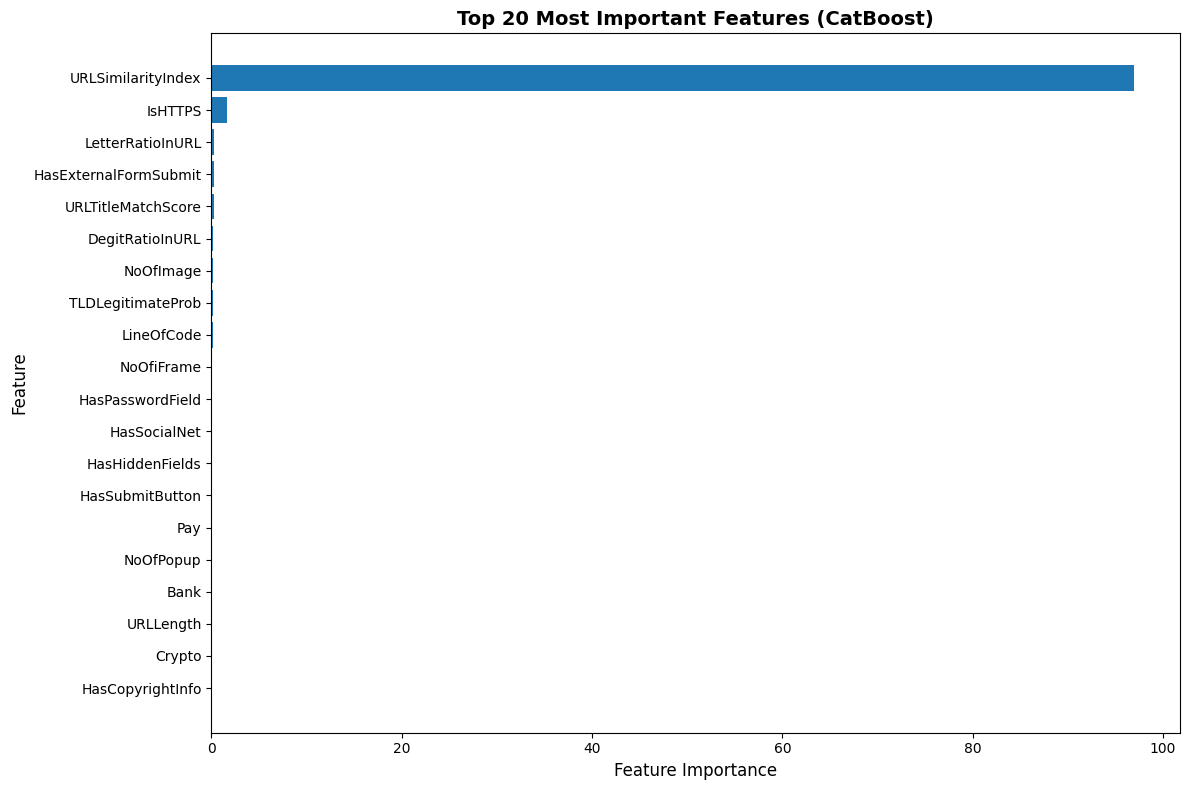


✅ CatBoost submission saved to: /Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission_catboost.csv


In [3]:
# CatBoost Implementation
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data
train = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/train.csv")
test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

# Separate features and target
X_train = train.drop(columns=['label'])
y_train = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("=== Data Overview ===")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Categorical column names: {categorical_cols}")

# CatBoost can handle categorical features natively!
# Just need to impute missing values
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Combine transformers (no encoding needed!)
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert back to DataFrame to preserve feature names
all_cols = numeric_cols + categorical_cols
X_train_df = pd.DataFrame(X_train_processed, columns=all_cols)
X_test_df = pd.DataFrame(X_test_processed, columns=all_cols)

# Identify which columns are categorical (by index after preprocessing)
cat_features_idx = [i for i, col in enumerate(all_cols) if col in categorical_cols]

print(f"\nCategorical feature indices: {cat_features_idx}")

# Create CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500,           # Number of boosting iterations
    learning_rate=0.05,       # Learning rate
    depth=8,                  # Tree depth
    l2_leaf_reg=3,           # L2 regularization
    subsample=0.8,           # Row sampling
    random_seed=42,
    verbose=100,             # Print progress every 100 iterations
    cat_features=cat_features_idx,  # Specify categorical features
    eval_metric='AUC',
    task_type='CPU'          # Use 'GPU' if you have GPU available
)

# Train the model
print("\n=== Training CatBoost ===")
catboost_model.fit(
    X_train_df, 
    y_train,
    eval_set=(X_test_df, y_test),
    early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
    verbose=100
)

# Evaluate on training set
y_train_pred = catboost_model.predict(X_train_df)
y_train_proba = catboost_model.predict_proba(X_train_df)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"\n=== Training Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training AUC: {train_auc:.4f}")

# Evaluate on test set
y_test_pred = catboost_model.predict(X_test_df)
y_test_proba = catboost_model.predict_proba(X_test_df)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n=== Test Set Performance ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Confusion Matrix
print("\n=== Confusion Matrix (Test Set) ===")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

print("\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing']))

# Feature importance
print("\n=== Top 20 Feature Importances ===")
feature_importance = pd.DataFrame({
    'feature': all_cols,
    'importance': catboost_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Most Important Features (CatBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save predictions to submission file
submission_catboost = pd.DataFrame({
    "index": test.index,
    "label": y_test_proba
})

submission_path = "/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/submission_catboost.csv"
submission_catboost.to_csv(submission_path, index=False)
print(f"\n✅ CatBoost submission saved to: {submission_path}")

# Store model for later comparison
catboost_pipeline = catboost_model

## Check Feature Importance

=== Feature Importance Analysis ===

Total features after preprocessing: 250
  - Numeric features: 50
  - Categorical features (after encoding): 200

=== Top 20 Most Important Features ===
                   feature  importance
        URLSimilarityIndex    0.552401
           NoOfExternalRef    0.254846
               NoOfSelfRef    0.041563
              NoOfEmptyRef    0.034864
                LineOfCode    0.031889
              HasSocialNet    0.012075
            HasDescription    0.009920
NoOfOtherSpecialCharsInURL    0.007095
                   IsHTTPS    0.006119
                 URLLength    0.004085
 Domain_infrequent_sklearn    0.003294
          HasCopyrightInfo    0.003051
             NoOfSubDomain    0.002648
                 NoOfImage    0.002469
                NoOfiFrame    0.002125
                   NoOfCSS    0.002112
           NoOfDegitsInURL    0.001955
           NoOfEqualsInURL    0.001939
                   TLD_app    0.001828
          NoOfLettersInURL    0

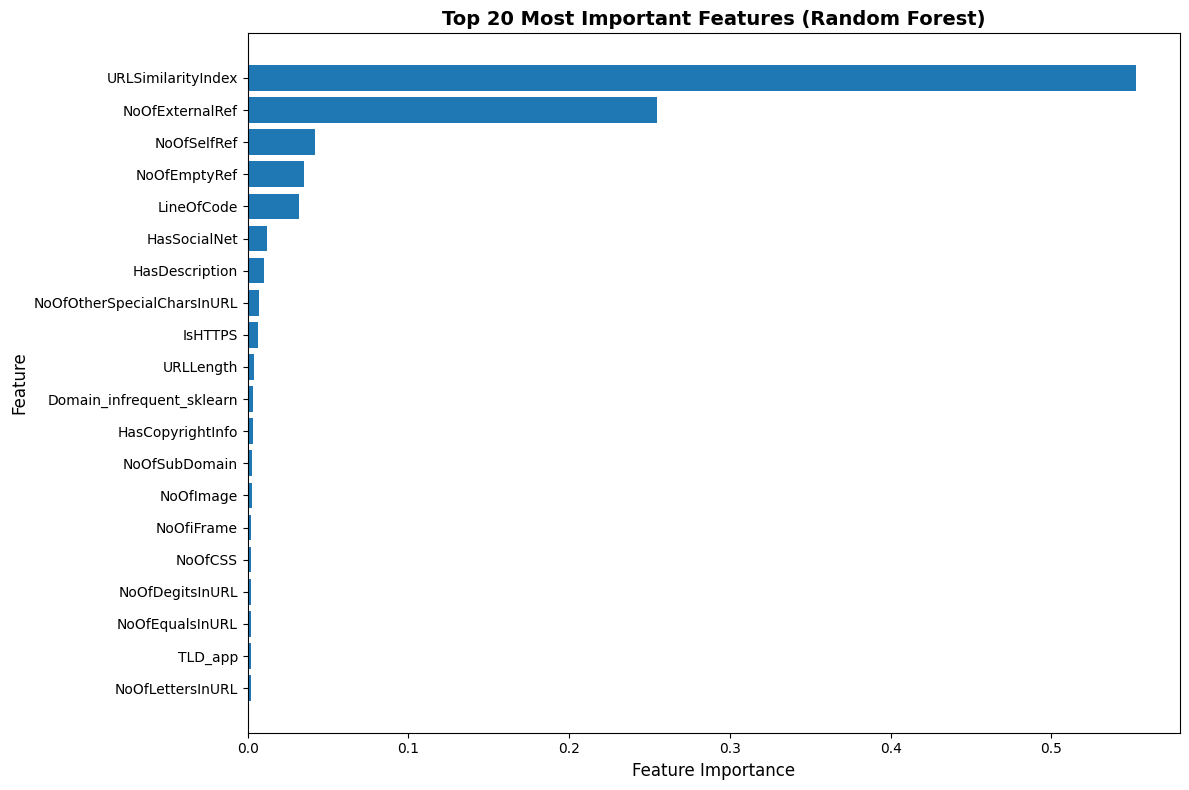

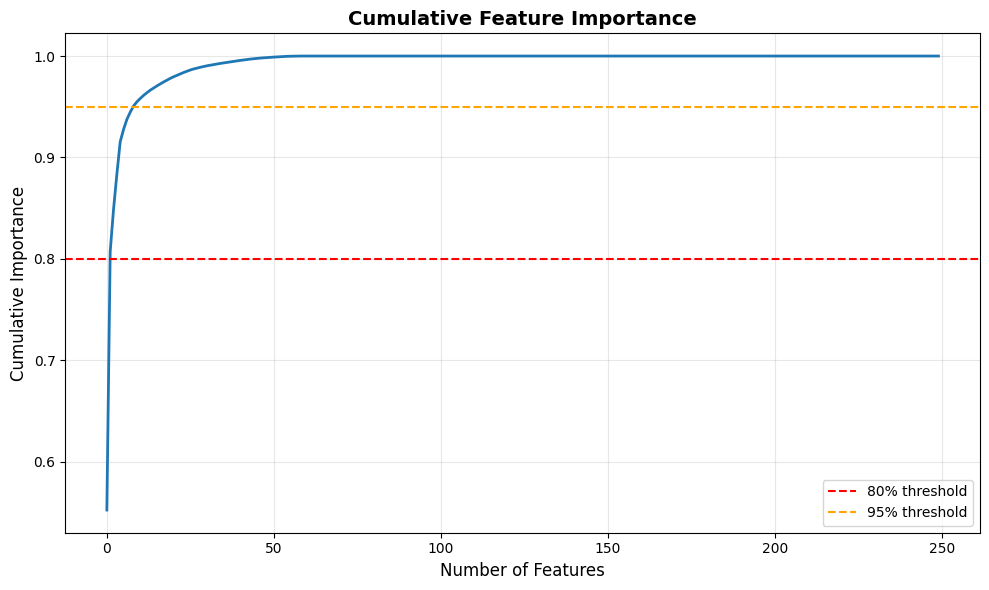

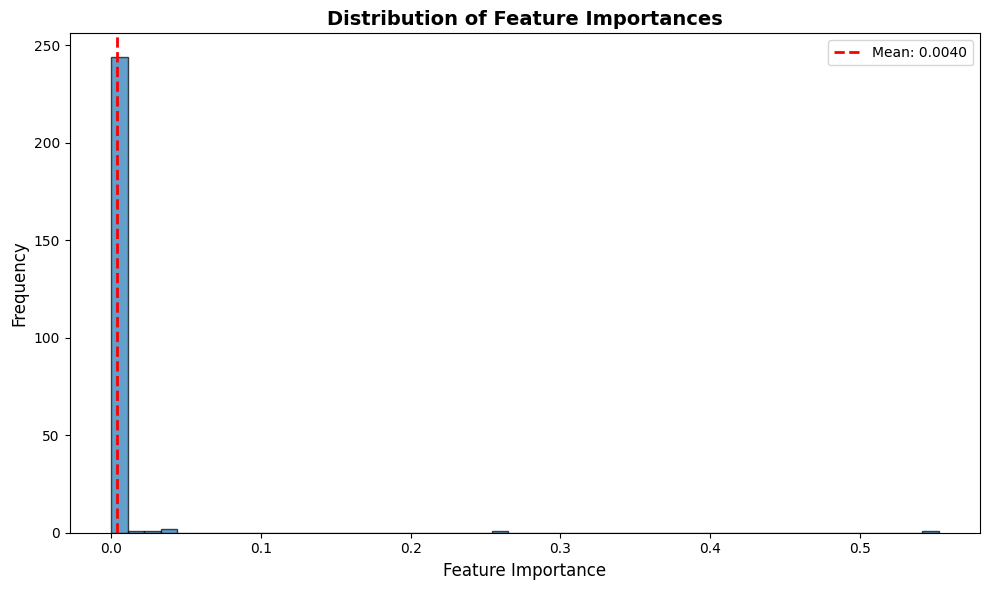


✅ Feature importance analysis complete!


In [5]:
# Feature Importance Analysis for Random Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check if pipeline exists from previous cell
if 'pipeline' not in dir():
    print("❌ Pipeline not found. Please run the Random Forest cell first.")
else:
    print("=== Feature Importance Analysis ===\n")
    
    # Get the trained Random Forest model from pipeline
    rf_model = pipeline.named_steps['model']
    
    # Get feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get numeric column names (unchanged)
    numeric_features = list(preprocessor.transformers_[0][2])
    
    # Get categorical feature names after one-hot encoding
    cat_transformer = preprocessor.transformers_[1][1]
    categorical_features = list(cat_transformer.named_steps['encoder'].get_feature_names_out(
        preprocessor.transformers_[1][2]
    ))
    
    # Combine all feature names
    all_feature_names = numeric_features + categorical_features
    
    print(f"Total features after preprocessing: {len(all_feature_names)}")
    print(f"  - Numeric features: {len(numeric_features)}")
    print(f"  - Categorical features (after encoding): {len(categorical_features)}\n")
    
    # Get feature importances
    feature_importances = rf_model.feature_importances_
    
    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    # Display top 20 features
    print("=== Top 20 Most Important Features ===")
    print(importance_df.head(20).to_string(index=False))
    
    # Display bottom 10 features (least important)
    print("\n=== Bottom 10 Least Important Features ===")
    print(importance_df.tail(10).to_string(index=False))
    
    # Statistics
    print(f"\n=== Feature Importance Statistics ===")
    print(f"Mean importance: {importance_df['importance'].mean():.6f}")
    print(f"Median importance: {importance_df['importance'].median():.6f}")
    print(f"Max importance: {importance_df['importance'].max():.6f}")
    print(f"Min importance: {importance_df['importance'].min():.6f}")
    
    # Count features with zero importance
    zero_importance = (importance_df['importance'] == 0).sum()
    print(f"Features with zero importance: {zero_importance}")
    
    # Top features that contribute to 80% of cumulative importance
    importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
    top_80_pct = importance_df[importance_df['cumulative_importance'] <= 0.8]
    print(f"\nNumber of features contributing to 80% importance: {len(top_80_pct)}")
    
    # Visualizations
    print("\n=== Generating Visualizations ===")
    
    # 1. Bar plot of top 20 features
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative importance plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(importance_df)), importance_df['cumulative_importance'], linewidth=2)
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    plt.axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Distribution of feature importances
    plt.figure(figsize=(10, 6))
    plt.hist(importance_df['importance'], bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Importances', fontsize=14, fontweight='bold')
    plt.axvline(importance_df['importance'].mean(), color='r', linestyle='--', 
                linewidth=2, label=f'Mean: {importance_df["importance"].mean():.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Feature importance analysis complete!")

## Checking accuracy against test

In [8]:
# Check accuracy of submission.csv against test.csv
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Load submission and test data
submission = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/tree_models/xgboost.csv")
test = pd.read_csv("/Users/maximus/Downloads/SCHOOL/bt4012/BT4012-Group-13/dataset/test.csv")

print("=== Data Info ===")
print(f"Submission shape: {submission.shape}")
print(f"Test shape: {test.shape}")
print(f"\nSubmission columns: {submission.columns.tolist()}")
print(f"Submission head:\n{submission.head()}")

# Get true labels from test set
y_true = test['label'].values

# Get predicted probabilities from submission
y_pred_proba = submission['label'].values

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)

print("\n" + "="*50)
print("=== SUBMISSION PERFORMANCE ON TEST SET ===")
print("="*50)
print(f"Accuracy: {accuracy}")
print(f"ROC-AUC:  {roc_auc}")

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Phishing']))

# Check prediction distribution
print("\n=== Prediction Distribution ===")
print(f"Predicted Legitimate (0): {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.2f}%)")
print(f"Predicted Phishing (1):   {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.2f}%)")
print(f"\nActual Legitimate (0):    {(y_true == 0).sum():,} ({(y_true == 0).sum()/len(y_true)*100:.2f}%)")
print(f"Actual Phishing (1):      {(y_true == 1).sum():,} ({(y_true == 1).sum()/len(y_true)*100:.2f}%)")

=== Data Info ===
Submission shape: (70739, 2)
Test shape: (70739, 56)

Submission columns: ['index', 'label']
Submission head:
   index     label
0      0  0.000347
1      1  0.000435
2      2  0.999550
3      3  0.999556
4      4  0.999542

=== SUBMISSION PERFORMANCE ON TEST SET ===
Accuracy: 0.9999858635264847
ROC-AUC:  1.0

=== Confusion Matrix ===
[[40455     0]
 [    1 30283]]

True Negatives:  40,455
False Positives: 0
False Negatives: 1
True Positives:  30,283

=== Classification Report ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     40455
    Phishing       1.00      1.00      1.00     30284

    accuracy                           1.00     70739
   macro avg       1.00      1.00      1.00     70739
weighted avg       1.00      1.00      1.00     70739


=== Prediction Distribution ===
Predicted Legitimate (0): 40,456 (57.19%)
Predicted Phishing (1):   30,283 (42.81%)

Actual Legitimate (0):    40,455 (57.19%)
Actual Ph